In [1]:
import os
from glob import glob
from pprint import pprint # pretty printing

import pandas as pd      # data structures
import numpy as np       # basic numerical operations
import altair as alt     # plotting library
from ipywidgets import interact, fixed # buttons and stuff
# with respect to https://github.com/Chekos/blog-posts/tree/master/altair%20%2B%20ipywidgets

# tell plotting library not to try and hold everything in memory
alt.data_transformers.enable('json')
# and let it render good
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## 1. *Geddat that data*
we reduced our spiketime data into 'long' format data - where every row is an observation (in this case spikes) and every column a variable.

But we still have every cell as its own damn file

In [2]:
# Get some files
cwd = os.getcwd()
# make a string to select our spikes files
spike_str = "{}{}*spikes.csv".format(cwd, os.sep)
print("Spike string: " +spike_str)

fns = glob(spike_str)
pprint(fns)

Spike string: /Users/jonny/GitHub/bootcamp_2018/*spikes.csv
['/Users/jonny/GitHub/bootcamp_2018/out_134_spikes.csv',
 '/Users/jonny/GitHub/bootcamp_2018/out_172_spikes.csv']


In [3]:
def as_spikenum(filename):
    split = filename.split("_")
    numbers = [s for s in split if s.isdigit()]
    if len(numbers)==1:
        return numbers[0]
    else:
        print("Found more than one number, giving you the last?")
        return numbers[-1]
    

df = pd.read_csv(fns[0]) # read the first (zero-indexed) file
df['cell'] = as_spikenum(fns[0])

# if we have more, read them too, assuming they're of the same format
if len(fns)>1:
    for fn in fns:
        adf = pd.read_csv(fn)
        adf['cell'] = as_spikenum(fn)
        
        # concatenate, ignoring a row index which doesn't help us much.
        df = pd.concat([df,adf],
                       ignore_index=True)
        
df.shape

(8232, 4)

How many cells do we have?

In [ ]:
print("There are {} unique cells: {}".format(
        len(df['cell'].unique()), 
        df['cell'].unique()
    ))

In [ ]:
df.head()

We presented probably like 9 stimuli:

In [ ]:
df['icis'].unique()

Maybe 20(?) times

In [ ]:
df['rep'].unique()

## 2. Look at it

We make a classic raster first.

In [ ]:

def spike_raster(cell, data):
    # we first declare a Chart object, subsetting our data to a single cell
    # we then mark_circles with the encoding (map from data to graphics)
    chart = alt.Chart(data[data['cell'] == cell]).mark_circle().encode(
        x = alt.X('spikes'),      # X axis will be spike time
        y = alt.Y('rep' ),        # Y is the stimulus repetition
        size = alt.value(5),      # make the dots small
        opacity=alt.value(1.),    # black
        color=alt.value('black'), # and opaque
        
    ).properties(
        width = 600,
        height = 30,
    ).facet(
        row='icis' # split the plot into rows by ici
    )
    
    
    return chart


In [ ]:
interact(spike_raster,cell = sorted(df['cell'].unique()), data=fixed(df));

What if we want to summarize?


In [4]:
# select just spikes within stim
stim_inds = np.logical_and(df['spikes']>0, df['spikes']<2000)
data_stim = df[stim_inds]

# summarize 


In [5]:
n_spikes = data_stim.groupby(['cell','icis','rep'])['spikes'].count()
n_spikes

cell  icis  rep
134   1     1      16
            2      10
            3      28
            4      14
            5       8
            6       8
            7       2
            8       8
            9      16
            10     16
            11      6
            12     20
            13     22
            14      6
            15      8
            16     18
            17      6
            18     14
            19     14
            20      2
      2     1      20
            2      12
            3      24
            4       2
            5      18
            6       8
            7      26
            8       4
            9       4
            11      2
                   ..
172   128   11     15
            12      3
            13      5
            14      1
            15      6
            16      5
            17      2
            18     12
            19      8
            20      6
      256   1       7
            2       7
            3       8
            4   

In [6]:
mean_spikes = pd.DataFrame(n_spikes.groupby(['cell','icis']).mean())
mean_spikes

spikes
cell icis           
134  1     12.100000
     2     11.333333
     4      6.857143
     8      4.111111
     16     8.333333
     32    14.000000
     64    14.500000
     128   17.700000
     256   19.100000
172  1      6.050000
     2      5.666667
     4      3.428571
     8      2.055556
     16     4.166667
     32     7.000000
     64     7.250000
     128    8.850000
     256    9.550000

In [7]:
sd_spikes = pd.DataFrame(n_spikes.groupby(['cell','icis']).std())
sd_spikes

spikes
cell icis           
134  1      6.851047
     2      8.622815
     4      5.695574
     8      2.698341
     16     5.235625
     32     8.137704
     64     7.783248
     128   10.588474
     256    8.372260
172  1      3.425523
     2      4.311408
     4      2.847787
     8      1.349171
     16     2.617812
     32     4.068852
     64     3.891624
     128    5.294237
     256    4.186130

Recombine them


In [8]:


stim_summary = pd.DataFrame.join(mean_spikes,sd_spikes, lsuffix='mean')
stim_summary = pd.DataFrame(stim_summary.to_records())
stim_summary['sd_low'] = stim_summary['spikesmean']-stim_summary['spikes']
stim_summary['sd_hi'] = stim_summary['spikesmean']+stim_summary['spikes']


stim_summary

,cell,icis,spikesmean,spikes,sd_low,sd_hi
0,134,1,12.100000,6.851047,5.248953,18.951047
1,134,2,11.333333,8.622815,2.710518,19.956148
2,134,4,6.857143,5.695574,1.161569,12.552717
3,134,8,4.111111,2.698341,1.412770,6.809452
4,134,16,8.333333,5.235625,3.097709,13.568958
5,134,32,14.000000,8.137704,5.862296,22.137704
6,134,64,14.500000,7.783248,6.716752,22.283248
7,134,128,17.700000,10.588474,7.111526,28.288474
8,134,256,19.100000,8.372260,10.727740,27.472260
9,172,1,6.050000,3.425523,2.624477,9.475523


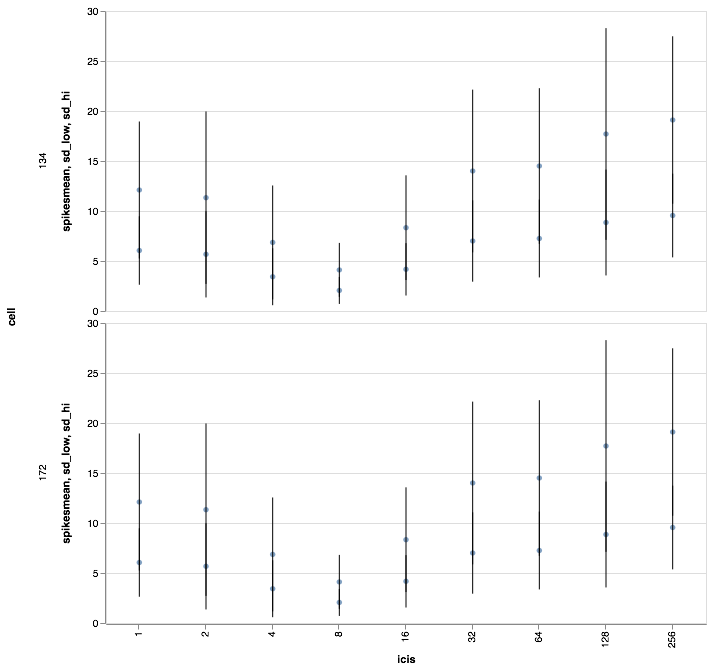

In [16]:
points = alt.Chart(stim_summary).mark_circle(
            ).encode(
                x=alt.X('icis:O'),
                y=alt.Y('spikesmean')
            ).properties(
                width = 600,
                height = 300
            )

bars = alt.Chart(stim_summary).mark_rule().encode(
y=alt.Y('sd_low'),
y2=alt.Y('sd_hi'),
x=alt.X('icis:O'))

chart = points+bars

chart.facet(row='cell:N',data=stim_summary)
